# TensorFlow Convolutional Neural Network for Image Classification

In [1]:
# !pip install -r tf2_requirements.txt

In [2]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

2022-06-12 13:11:38.465070: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-12 13:11:38.534456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-12 13:11:38.534485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configuration and Hyperparameters

In [3]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Ratha poriyal', 'Kadalai mittai', 'Beetroot Poriyal', 'Appam', 'Carrot Poriyal', 'Egg gravy', 'Thenmittai', 'Paruppu Poli', 'Baby potato fry', 'Dosa', 'Ennai kathirikai karakulambu', 'Omelet', 'Chicken 65', 'Biryani', 'Sambar', 'Bonda', 'Murukku', 'Avarakai Poriyal', 'Coconut chutney', 'Methu vadai', 'Vanjiram fry', 'Boondhi raita', 'Kuzhi Paniyaram', 'Lemon rice', 'Pori urundai', 'Malabar Parotta', 'Mutton chukka', 'Adirasam', 'Gulab jamun', 'Idiyappam']
num_classes = len(classes)

# batch size
batch_size = 64

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'data/train/'
test_path = 'data/test/'
checkpoint_dir = "models/"

## Load Data

In [4]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading Ratha poriyal files (Index: 0)
Loading Kadalai mittai files (Index: 1)
Loading Beetroot Poriyal files (Index: 2)
Loading Appam files (Index: 3)
Loading Carrot Poriyal files (Index: 4)
Loading Egg gravy files (Index: 5)
Loading Thenmittai files (Index: 6)
Loading Paruppu Poli files (Index: 7)
Loading Baby potato fry files (Index: 8)
Loading Dosa files (Index: 9)
Loading Ennai kathirikai karakulambu files (Index: 10)
Loading Omelet files (Index: 11)
Loading Chicken 65 files (Index: 12)
Loading Biryani files (Index: 13)
Loading Sambar files (Index: 14)
Loading Bonda files (Index: 15)
Loading Murukku files (Index: 16)
Loading Avarakai Poriyal files (Index: 17)
Loading Coconut chutney files (Index: 18)
Loading Methu vadai files (Index: 19)
Loading Vanjiram fry files (Index: 20)
Loading Boondhi raita files (Index: 21)
Loading Kuzhi Paniyaram files (Index: 22)
Loading Lemon rice files (Index: 23)
Loading Pori urundai files (Index: 24)
Loading Malabar Parotta fi

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		10047
- Validation-set:	1913


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(np.array(image))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

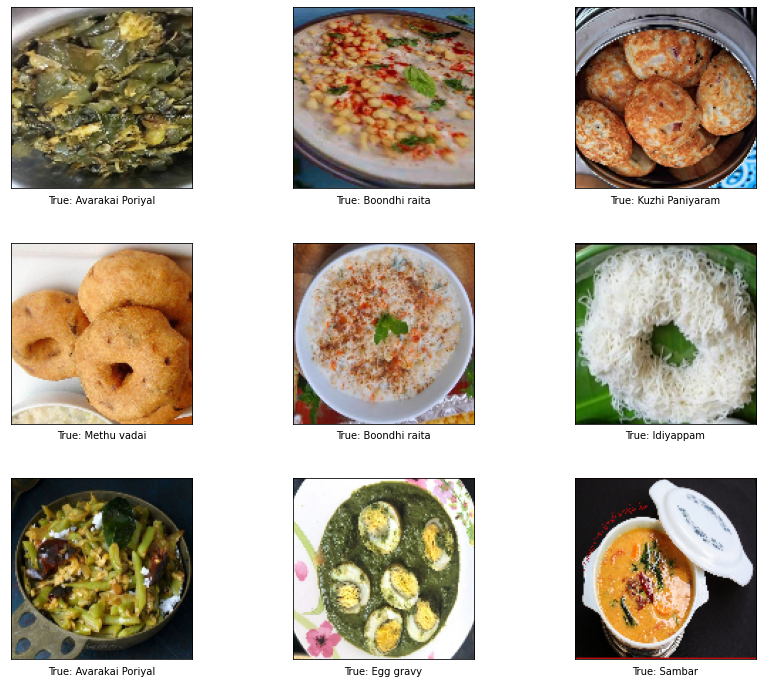

In [7]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

### Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_filters1, filter_size1, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(img_size, img_size, num_channels)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(num_filters3, filter_size3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_size, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

2022-06-12 13:12:59.531526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/k/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-06-12 13:12:59.532043: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-12 13:12:59.532483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kar): /proc/driver/nvidia/version does not exist
2022-06-12 13:12:59.534808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TensorFlow Run

### Helper-function to perform optimization iterations

It takes a long time to calculate the gradient of the model using the entirety of a large dataset
. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [9]:
train_batch_size = batch_size

In [10]:
def print_progress(epoch, train_acc, val_acc, val_loss):
    msg = f"Epoch {epoch} --- Training Accuracy: {train_acc:>6.1%}, Validation Accuracy: {val_acc:>6.1%}, Validation Loss: {val_loss:.3f}"
    print(msg)

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [11]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):
        # Reset the metric accumulators
        model.reset_metrics()

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        result = model.train_on_batch(x_batch, y_true_batch) 
        train_acc = result[1]

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss, val_acc = model.test_on_batch(x_valid_batch, y_valid_batch, reset_metrics=False)
            epoch = int(i / int(data.train.num_examples/batch_size))
            metrics_names = model.metrics_names
            
            print_progress(epoch, train_acc, val_acc, val_loss)
            
            # print(type(val_acc))
            # print(str(val_acc))
            
            if val_acc > 0.84:
                break
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [12]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [13]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [14]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = np.argmax(model(images), 1)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [15]:
train(num_iterations=1)
print_validation_accuracy()

Epoch 0 --- Training Accuracy:   3.1%, Validation Accuracy:   1.6%, Validation Loss: 7.536
Time elapsed: 0:00:01


/tmp/ipykernel_53187/1284072627.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 3.9% (75 / 1913)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [16]:
train(num_iterations=99)  # We already performed 1 iteration above.

Time elapsed: 0:00:23


/tmp/ipykernel_53187/1284072627.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 2.8% (54 / 1913)
Example errors:


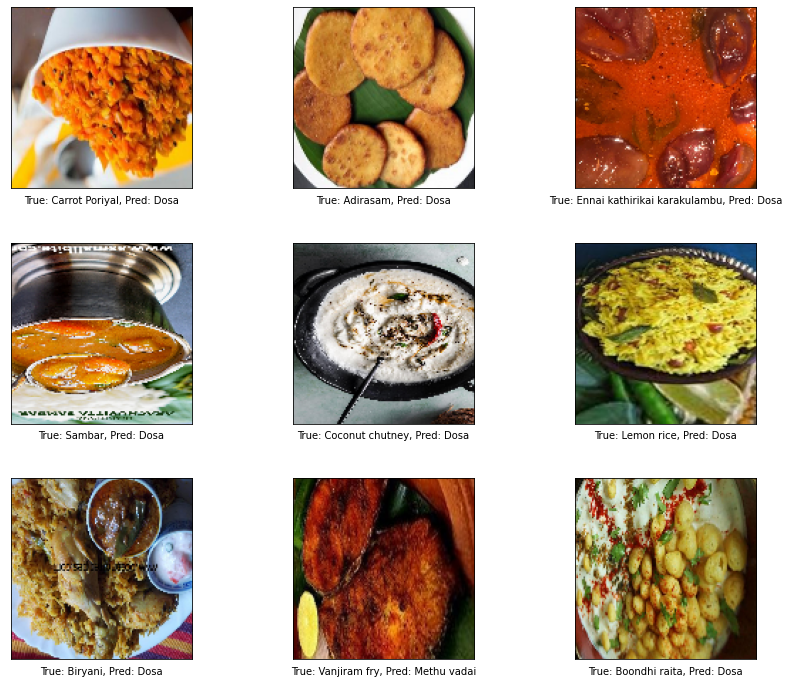

In [17]:
print_validation_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

In [18]:
train(num_iterations=900)  # We performed 100 iterations above.

Epoch 1 --- Training Accuracy:  31.2%, Validation Accuracy:  17.2%, Validation Loss: 7.168
Epoch 2 --- Training Accuracy:  35.9%, Validation Accuracy:  20.3%, Validation Loss: 7.226
Epoch 3 --- Training Accuracy:  46.9%, Validation Accuracy:  32.8%, Validation Loss: 5.541
Epoch 4 --- Training Accuracy:  59.4%, Validation Accuracy:  43.0%, Validation Loss: 4.474
Epoch 5 --- Training Accuracy:  62.5%, Validation Accuracy:  46.9%, Validation Loss: 3.931
Epoch 6 --- Training Accuracy:  67.2%, Validation Accuracy:  47.7%, Validation Loss: 4.031
Time elapsed: 0:03:29


/tmp/ipykernel_53187/1284072627.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 38.8% (742 / 1913)
Example errors:


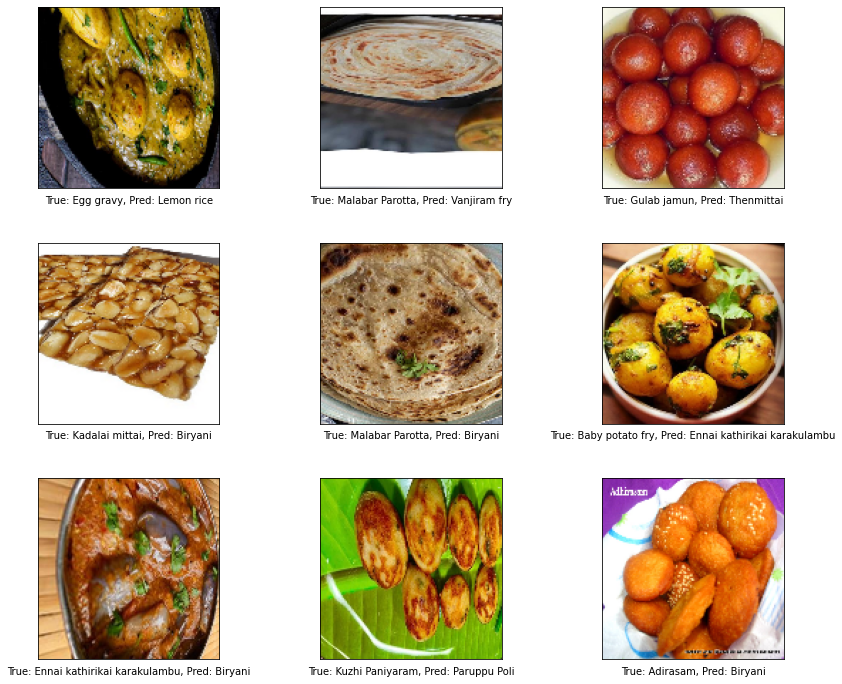

In [19]:
print_validation_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

In [21]:
train(num_iterations=9000) # We performed 1000 iterations above.

Epoch 7 --- Training Accuracy:  71.9%, Validation Accuracy:  58.6%, Validation Loss: 3.337
Epoch 8 --- Training Accuracy:  70.3%, Validation Accuracy:  51.6%, Validation Loss: 3.251
Epoch 9 --- Training Accuracy:  87.5%, Validation Accuracy:  66.4%, Validation Loss: 2.962
Epoch 10 --- Training Accuracy:  93.8%, Validation Accuracy:  73.4%, Validation Loss: 2.497
Epoch 11 --- Training Accuracy:  92.2%, Validation Accuracy:  66.4%, Validation Loss: 2.629
Epoch 12 --- Training Accuracy:  90.6%, Validation Accuracy:  71.1%, Validation Loss: 2.396
Epoch 13 --- Training Accuracy:  93.8%, Validation Accuracy:  71.1%, Validation Loss: 2.566
Epoch 14 --- Training Accuracy:  98.4%, Validation Accuracy:  69.5%, Validation Loss: 2.161
Epoch 15 --- Training Accuracy:  98.4%, Validation Accuracy:  68.8%, Validation Loss: 2.187
Epoch 16 --- Training Accuracy:  95.3%, Validation Accuracy:  79.7%, Validation Loss: 1.808
Epoch 17 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Los

/tmp/ipykernel_53187/1284072627.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 84.6% (1618 / 1913)
Example errors:


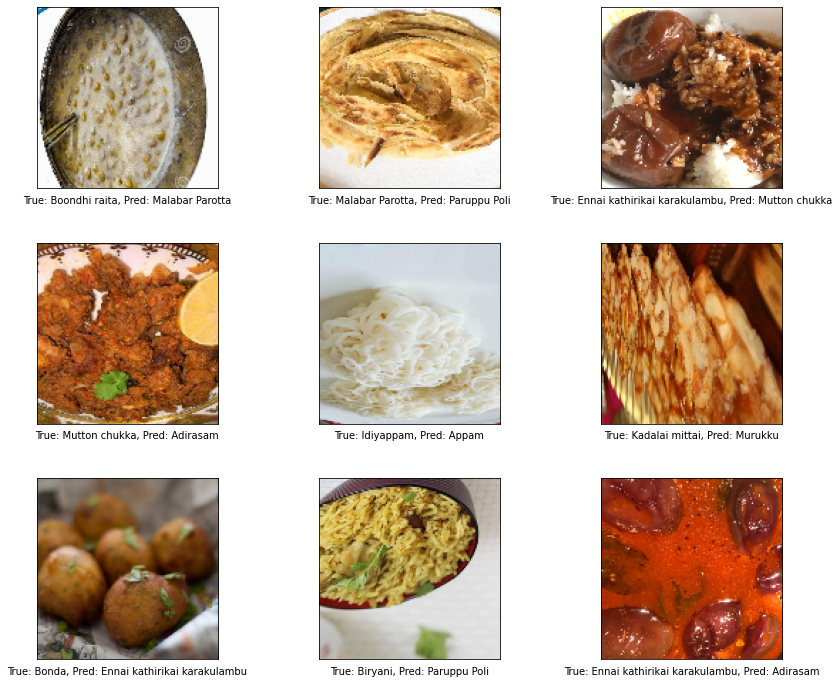

Confusion Matrix:
[[31  0  0  0  0  2  0  0  0  1  0  3  1  2  6  0  0  2  0  0  2  2  0  0
   0  0  0  1  0  1]
 [ 0 52  0  0  0  1  0  0  0  0  1  3  0  0  0  0  0  0  0  1  0  0  0  0
   1  1  1  0  0  0]
 [ 0  0 60  0  0  2  0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0  1  0
   0  0  7  0  0  0]
 [ 3  0  2 20  0  4  0  0  0  0  0  1 12  3  1  0  2  3  0  0  2  0  8  0
   0  1  1  0  0  0]
 [ 0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  6  0  0  0]
 [ 1  0  4  0  0 36  0  1  1  0  0  1  1  1  0  0  0  0  1  2  0  3  3  1
   6 11  1  0  0  0]
 [ 1  2  0  7  0  1 15  0  1  0  0  8  3  1  3  0  0  4  0  0  7  0  0  2
   4  0  0  4  0  1]
 [ 0  6  2  0  0  8  0 19  0  0  4  2  1  1  0  2  1  0  0  6  0  0  0  2
   2  5  1  0  0  0]
 [ 1  0  2  3  0 10  1  1 19  0  0  1 13  1  2  0  0  0  1  0  0  2  4  4
   0  2  0  0  0  0]
 [ 4  0  1  9  4  2  0  0  0 18  0  0  3  0  2  0  0  0  0  0  0  1 12  0
   0  0  3  0  1  8]
 [ 0  9  0  0  0  0  0  2  0  0 

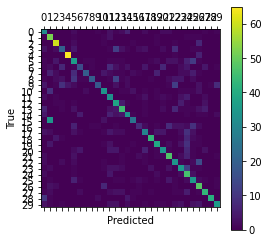

In [22]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [23]:
model.save('my_model_final.h5') 

## Test on Sample Image

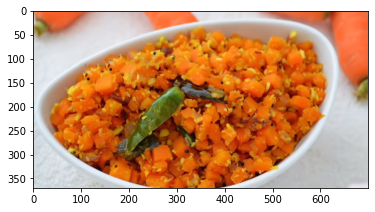

In [25]:
# plt.axis('off')

test_cporiyal = cv2.imread('Carrot_Poriyal.jpg')

plt.imshow(cv2.cvtColor(test_cporiyal, cv2.COLOR_BGR2RGB))
plt.show()

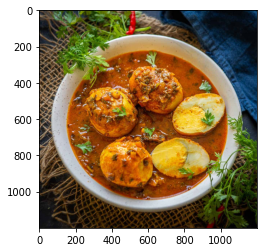

In [26]:
test_egg = cv2.imread('Egg_Masala.jpg')

plt.imshow(cv2.cvtColor(test_egg, cv2.COLOR_BGR2RGB))
plt.show()

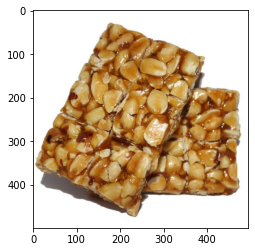

In [27]:
test_kadalai = cv2.imread('kadalai_mittai.png')

plt.imshow(cv2.cvtColor(test_kadalai, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
def sample_prediction(test_im):
    test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255
    test_pred = np.argmax(model(test_im.reshape((1, img_size, img_size, 3))))
    return classes[test_pred]

print("Predicted class for test_cporiyal : {}".format(sample_prediction(test_cporiyal)))
print("Predicted class for test_egg : {}".format(sample_prediction(test_egg)))
print("Predicted class for test_kadalai : {}".format(sample_prediction(test_kadalai)))

Predicted class for test_cporiyal : Carrot Poriyal
Predicted class for test_egg : Paruppu Poli
Predicted class for test_kadalai : Kadalai mittai
